### Read the train and test logits/likelyhoods

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import f1_score
from netcal.metrics import ECE
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from tqdm import tqdm
import pydensecrf.densecrf as dcrf
import optuna

val_path = 'calibration_logits.pth'
test_path = 'test_logits.pth'

val_data = torch.load(val_path, weights_only=False)
test_data = torch.load(test_path, weights_only=False)

val_logits = val_data["logits"] 
val_images = val_data["images"]  
val_labels = val_data["masks"]    
val_probs = F.softmax(val_logits, dim=1)

test_logits = test_data["logits"] 
test_images = test_data["images"]  
test_labels = test_data["masks"]    
test_probs = F.softmax(test_logits, dim=1)

print("Validation logits shape:", val_logits.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Validation probabilities shape:", val_probs.shape)       

Validation logits shape: torch.Size([21, 4, 966, 1296])
Validation images shape: torch.Size([21, 3, 966, 1296])
Validation labels shape: torch.Size([21, 966, 1296])
Validation probabilities shape: torch.Size([21, 4, 966, 1296])


### Frameworks

#### FrameMetrics

In [2]:
class FrameMetrics:

    def compute_ece(probs, labels, n_bins=10):
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C) 
        labels_flat = labels.view(-1)  # (N*H*W,)
        probs_np  = probs_flat.detach().cpu().numpy()  
        labels_np = labels_flat.detach().cpu().numpy() 
        
        ece = ECE(bins=n_bins)
        ece_score = ece.measure(probs_np, labels_np)
        return ece_score
    
    def compute_inbalance(labels):
        labels_flat = labels.view(-1)               
        labels_np   = labels_flat.detach().cpu().numpy()

        classes, counts = np.unique(labels_np, return_counts=True)
        total           = labels_np.shape[0]
        percentages     = counts / total * 100

        for cls, cnt, pct in zip(classes, counts, percentages):
            print(f"Classe {cls}: {cnt} samples — {pct:.2f}% of total")

        fig, ax = plt.subplots()
        bars = ax.bar(classes, counts)

        for bar, pct in zip(bars, percentages):
            ax.text(
                bar.get_x() + bar.get_width() / 2,  
                bar.get_height(),                   
                f'{pct:.2f}%',                      
                ha='center',                        
                va='bottom'                         
            )

        ax.set_xlabel('Index of class')
        ax.set_ylabel('Number of samples')
        ax.set_title('Class Distribution')
        ax.set_xticks(classes)
        plt.show()

    def compute_f1_score(probs, labels, num_classes): 
        N, C, H, W = probs.shape
        probs_flat = probs.permute(0, 2, 3, 1).reshape(-1, C)  
        labels_flat = labels.view(-1)  

        preds_flat = torch.argmax(probs_flat, dim=1)
        labels_np = labels_flat.cpu().numpy()
        preds_np = preds_flat.cpu().numpy()

        f1_per_class = f1_score(labels_np, preds_np, average=None,
                                labels=range(num_classes), zero_division=0)

        macro_f1 = f1_score(labels_np, preds_np, average='macro',
                               labels=range(num_classes), zero_division=0)

        return f1_per_class, macro_f1

#### Frame HyperparameterOptimizer

In [3]:
class FrameHyperparameterOptimizer:
    @staticmethod
    def optimize_hyperparameters_bayesian(initial_probs, labels, num_classes=4, n_calls=75, random_state=42):
        N, C, H, W = initial_probs.shape
        
        space = [
            Real(0.01, 0.5, name='penalty_factor')
        ]
        for i in range(num_classes):
            space.append(Real(0.01, 0.99, name=f'quartile_threshold_class_{i}'))

        @use_named_args(space)
        def objective(**params):
            penalty_factor = params['penalty_factor']
            
            probs_flat = initial_probs.permute(0, 2, 3, 1).reshape(-1, C)
            labels_flat = labels.view(-1)
            
            confidence_scores_gt = torch.gather(probs_flat, 1, labels_flat.unsqueeze(1)).squeeze(1)

            current_threshold_values = torch.zeros(num_classes, device=initial_probs.device)
            for i in range(num_classes):
                quartile_percentile = params[f'quartile_threshold_class_{i}']
                class_i_mask = (labels_flat == i)
                if torch.sum(class_i_mask) > 0:
                    scores_for_class_i = confidence_scores_gt[class_i_mask]
                    threshold_value = np.percentile(scores_for_class_i.cpu().numpy(), quartile_percentile * 100)
                else:
                    threshold_value = 0.0
                current_threshold_values[i] = threshold_value

            adjusted_probs = probs_flat.clone()
            predicted_class_orig_flat = torch.argmax(probs_flat, dim=1)
            
            confidence_score_for_each_pixel = torch.max(probs_flat, dim=1).values
            
            threshold_for_each_pixel = current_threshold_values[predicted_class_orig_flat]

            uncertain_mask = (confidence_score_for_each_pixel < threshold_for_each_pixel)
            is_not_background_mask = (predicted_class_orig_flat != 0)
            final_uncertain_mask = uncertain_mask & is_not_background_mask
            
            if torch.any(final_uncertain_mask):
                one_hot_pred_class = torch.nn.functional.one_hot(predicted_class_orig_flat, num_classes=num_classes)
                original_probs_uncertain = adjusted_probs[final_uncertain_mask]
                penalized_probs = original_probs_uncertain * penalty_factor
                value_removed = original_probs_uncertain - penalized_probs
                value_removed_summed = torch.sum(value_removed * one_hot_pred_class[final_uncertain_mask], dim=1)
                adjusted_probs[final_uncertain_mask] = penalized_probs
                
                current_bg_probs = adjusted_probs[final_uncertain_mask, 0]
                adjusted_probs[final_uncertain_mask, 0] = current_bg_probs + value_removed_summed
                
                adjusted_probs[final_uncertain_mask] /= torch.sum(adjusted_probs[final_uncertain_mask], dim=1, keepdim=True)

            adjusted_probs = torch.max(adjusted_probs, torch.tensor(1e-8, device=adjusted_probs.device))
            adjusted_probs = adjusted_probs / torch.sum(adjusted_probs, dim=1, keepdim=True)

            _, macro_f1 = FrameMetrics.compute_f1_score(
                adjusted_probs.reshape(N, H, W, C).permute(0, 3, 1, 2),
                labels,
                num_classes
            )
            return -macro_f1

        pbar = tqdm(total=n_calls, desc="Optimizing hyperparameters")
        def pbar_callback(res):
            pbar.update(1)
            pbar.set_postfix_str(f"Melhor F1 Macro: {-res.fun:.4f}")
        res = gp_minimize(objective, space, n_calls=n_calls, random_state=random_state, callback=pbar_callback)
        pbar.close()

        best_params = {space[i].name: res.x[i] for i in range(len(space))}
        return best_params
    
    def calculate_final_thresholds(best_hyperparams, initial_probs, labels):
        num_classes = initial_probs.shape[1]
        probs_flat = initial_probs.permute(0, 2, 3, 1).reshape(-1, num_classes)
        labels_flat = labels.view(-1)
        
        confidence_scores_gt = torch.gather(probs_flat, 1, labels_flat.unsqueeze(1)).squeeze(1)

        final_thresholds = {}
        for i in range(num_classes):
            quartile_percentile = best_hyperparams[f'quartile_threshold_class_{i}']
            class_i_mask = (labels_flat == i)
            threshold_value = 0.0
            if torch.sum(class_i_mask) > 0:
                scores_for_class_i = confidence_scores_gt[class_i_mask]
                threshold_value = np.percentile(scores_for_class_i.cpu().numpy(), quartile_percentile * 100)
            
            final_thresholds[f'class_{i}'] = {
                'quartile_percentile': quartile_percentile,
                'threshold_value': threshold_value
            }
        return final_thresholds

#### Frame CRF

In [4]:
class FrameCRFApproach:
    def __init__(self, num_classes, penalty_factor=0.1, epsilon=1e-8):
        self.num_classes = num_classes
        self.penalty_factor = penalty_factor
        self.epsilon = epsilon
        self.best_params = None
        self.thresholds_per_class = None
        self.class_threshold_values_tensor = None

    def set_optimal_thresholds(self, thresholds):
        self.thresholds_per_class = thresholds
        self.class_threshold_values_tensor = torch.zeros(self.num_classes)
        for i in range(self.num_classes):
            self.class_threshold_values_tensor[i] = thresholds.get(f'class_{i}', {}).get('threshold_value', 0.0)

    def _prepare_unary_energies(self, probs):
        if self.class_threshold_values_tensor is None:
            raise ValueError("Os limiares ótimos devem ser definidos com 'set_optimal_thresholds'.")
        
        device = probs.device
        self.class_threshold_values_tensor = self.class_threshold_values_tensor.to(device)

        adjusted_probs_permuted = probs.permute(1, 2, 0)
        
        predicted_classes = torch.argmax(probs, dim=0)
        confidence_score_for_each_pixel = torch.max(probs, dim=0).values
        threshold_for_each_pixel = self.class_threshold_values_tensor[predicted_classes.flatten()].reshape(predicted_classes.shape)
    
        uncertain_mask = (confidence_score_for_each_pixel < threshold_for_each_pixel)
        is_not_background_mask = (predicted_classes != 0)
        final_uncertain_mask = uncertain_mask & is_not_background_mask

        if torch.any(final_uncertain_mask):
            one_hot_pred_class = torch.nn.functional.one_hot(predicted_classes, self.num_classes)
            
            uncertain_pixel_probs = adjusted_probs_permuted[final_uncertain_mask]
            uncertain_one_hot = one_hot_pred_class[final_uncertain_mask]

            penalized_probs = uncertain_pixel_probs * self.penalty_factor
            
            value_removed = (uncertain_pixel_probs - penalized_probs) * uncertain_one_hot
            value_removed_summed = torch.sum(value_removed, dim=1)

            modified_probs = penalized_probs.clone()
            modified_probs[:, 0] = modified_probs[:, 0] + value_removed_summed

            sum_probs = torch.sum(modified_probs, dim=1, keepdim=True)
            modified_probs = modified_probs / (sum_probs + 1e-8)

            adjusted_probs_permuted[final_uncertain_mask] = modified_probs
        
        return adjusted_probs_permuted.permute(2, 0, 1).cpu().numpy()

    def _apply_crf_refinement(self, prob_unary, sxy_gaussian, compat_gaussian, iterations=10):
        C, H, W = prob_unary.shape
        d = dcrf.DenseCRF2D(W, H, C)
        unary = -np.log(np.maximum(prob_unary, self.epsilon)).reshape(C, -1).astype(np.float32)
        d.setUnaryEnergy(unary)
        d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian)
        Q = d.inference(iterations)
        return np.array(Q).reshape((C, H, W))

    def _crf_loss_for_optimization(self, params, val_probs, val_labels):
        n_samples = val_probs.shape[0]
        sxy_gaussian, compat_gaussian = params
        all_refined_probs = []

        pbar_desc = f"Optuna Trial (sxy={sxy_gaussian}, compat={compat_gaussian:.2f})"
        for i in tqdm(range(n_samples), desc=pbar_desc, leave=False):
            prepared_unary_np = self._prepare_unary_energies(val_probs[i])
            crf_refined_probs_np = self._apply_crf_refinement(prepared_unary_np, sxy_gaussian, compat_gaussian)
            all_refined_probs.append(torch.from_numpy(crf_refined_probs_np))

        all_refined_probs_tensor = torch.stack(all_refined_probs).to(val_labels.device)
        _, macro_f1 = FrameMetrics.compute_f1_score(all_refined_probs_tensor, val_labels, self.num_classes)
        return 1.0 - macro_f1

    def fit_crf_parameters(self, validation_probs, validation_labels, n_trials=10):
        print("\n--- Starting CRF Parameter Optimization with Optuna ---")
        study = optuna.create_study(direction="minimize")
        objective_func = lambda trial: self._crf_loss_for_optimization(
            [trial.suggest_categorical("sxy_gaussian", [1, 3, 5]), trial.suggest_float("compat_gaussian", 1.0, 5.0)],
            validation_probs, validation_labels
        )
        study.optimize(objective_func, n_trials=n_trials)
        self.best_params = study.best_params
        print(f"--- CRF Optimization Completed. Best parameters: {self.best_params} ---")

    def inference_with_optimized_crf(self, test_probs):
        if self.best_params is None or self.thresholds_per_class is None:
            raise ValueError("CRF parameters and class thresholds must be optimized/defined first.")

        print("\n--- Applying Optimized CRF on Test Set ---")
        n_samples = test_probs.shape[0]
        sxy = int(self.best_params["sxy_gaussian"])
        compat = float(self.best_params["compat_gaussian"])
        final_refined_probs_list = []

        for i in tqdm(range(n_samples), desc="Final Inference with CRF"):
            prepared_unary_np = self._prepare_unary_energies(test_probs[i])
            crf_refined_probs_np = self._apply_crf_refinement(prepared_unary_np, sxy, compat)
            final_refined_probs_list.append(torch.from_numpy(crf_refined_probs_np))

        final_refined_probs = torch.stack(final_refined_probs_list)
        final_predictions = final_refined_probs.argmax(dim=1)
        return final_refined_probs, final_predictions

### Check model calibration

In [5]:
ece_score = FrameMetrics.compute_ece(val_probs, val_labels, n_bins=10)
print(f"ECE Score: {ece_score:.4f}")

ECE Score: 0.0024


### Check class imbalance

Classe 0: 24946666 samples — 94.89% of total
Classe 1: 976055 samples — 3.71% of total
Classe 2: 327252 samples — 1.24% of total
Classe 3: 40683 samples — 0.15% of total


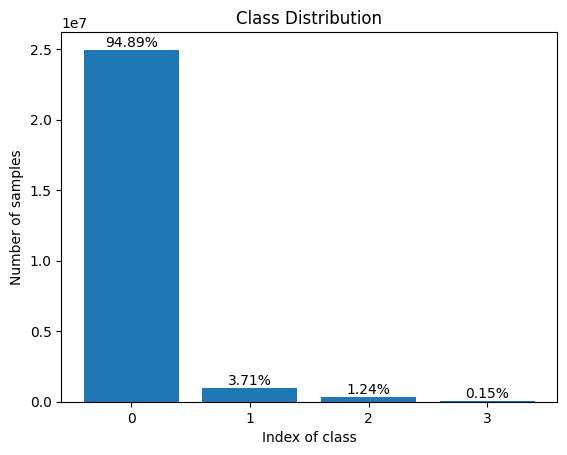

In [6]:
FrameMetrics.compute_inbalance(val_labels)

### Optimize Hyperparameters

In [7]:
print("Step 1 - Optimizing Hyperparameters with Bayesian Optimization...")

best_hyperparams = FrameHyperparameterOptimizer.optimize_hyperparameters_bayesian(
    initial_probs=val_probs,
    labels=val_labels,
    num_classes=4,
    n_calls=50
)

print(f"Best Hyperparameters Found: Penalty Factor {best_hyperparams['penalty_factor']:.4f}")

Step 1 - Optimizing Hyperparameters with Bayesian Optimization...


Optimizing hyperparameters: 100%|██████████| 50/50 [10:00<00:00, 12.01s/it, Melhor F1 Macro: 0.7567]

Best Hyperparameters Found: Penalty Factor 0.0100


### Threshold

In [8]:
print("Step 2 - Setting Optimal Hyperparameters for Thresholding...")

optimal_penalty_factor = best_hyperparams['penalty_factor']
final_threshold_dict = FrameHyperparameterOptimizer.calculate_final_thresholds(best_hyperparams, val_probs, val_labels)

print("\nFinal Thresholds for each class:")
for class_id, values in final_threshold_dict.items():
    print(f"  {class_id}: Quartile={values['quartile_percentile']:.4f} -> Threshold={values['threshold_value']:.4f}")

Step 2 - Setting Optimal Hyperparameters for Thresholding...

Final Thresholds for each class:
  class_0: Quartile=0.9900 -> Threshold=1.0000
  class_1: Quartile=0.0874 -> Threshold=0.5014
  class_2: Quartile=0.1824 -> Threshold=0.3093
  class_3: Quartile=0.4301 -> Threshold=0.3742


### Train CRF

In [9]:
print("Step 3 - Setting Optimal Hyperparameters for CRF...")

crf_optimizer = FrameCRFApproach(num_classes=4, penalty_factor=optimal_penalty_factor)
crf_optimizer.set_optimal_thresholds(final_threshold_dict)
crf_optimizer.fit_crf_parameters(validation_probs=val_probs, validation_labels=val_labels, n_trials=10)

[I 2025-07-31 13:54:14,190] A new study created in memory with name: no-name-b8495b78-ed2b-4b9c-9acf-1de7a001a74b


Step 3 - Setting Optimal Hyperparameters for CRF...

--- Starting CRF Parameter Optimization with Optuna ---


[I 2025-07-31 13:54:47,917] Trial 0 finished with value: 0.24493912765853976 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 2.4521652513061287}. Best is trial 0 with value: 0.24493912765853976.
[I 2025-07-31 13:55:21,641] Trial 1 finished with value: 0.24437667350660197 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 2.0688023022428785}. Best is trial 1 with value: 0.24437667350660197.
[I 2025-07-31 13:55:54,646] Trial 2 finished with value: 0.24712019505233918 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 1.8579945782361835}. Best is trial 1 with value: 0.24437667350660197.
[I 2025-07-31 13:56:28,149] Trial 3 finished with value: 0.24571642565886587 and parameters: {'sxy_gaussian': 3, 'compat_gaussian': 2.7951043623251968}. Best is trial 1 with value: 0.24437667350660197.
[I 2025-07-31 13:57:01,180] Trial 4 finished with value: 0.25786267461054513 and parameters: {'sxy_gaussian': 5, 'compat_gaussian': 3.1592052854823676}. Best is trial 1 with value: 0.244376673

--- CRF Optimization Completed. Best parameters: {'sxy_gaussian': 1, 'compat_gaussian': 4.989488909353236} ---


### Inference

In [10]:
print("Step 4 - Performing Final Inference and Evaluation (using test data)...")

final_refined_probs, final_predictions = crf_optimizer.inference_with_optimized_crf(test_probs=test_probs)

print("\nInference finalized. Evaluating results...")

Step 4 - Performing Final Inference and Evaluation (using test data)...

--- Applying Optimized CRF on Test Set ---


Final Inference with CRF: 100%|██████████| 43/43 [01:02<00:00,  1.46s/it]



Inference finalized. Evaluating results...


### FINAL PERFORMANCE

In [11]:
print("\n--- Performance Results (Macro F1-Score and Per Class) ---")

print("\n## Baseline (Deep Learning Model Only)")
baseline_f1_per_class, baseline_macro_f1 = FrameMetrics.compute_f1_score(test_probs, test_labels, num_classes=4)
print(f"F1-Score (Macro): {baseline_macro_f1:.4f}")
print("F1-Score Per Class:")
for i, f1 in enumerate(baseline_f1_per_class):
    print(f"  Class {i}: {f1:.4f}")

print("\n## Your Refined Approach (DL + Thresholds + CRF)")
refined_f1_per_class, refined_macro_f1 = FrameMetrics.compute_f1_score(final_refined_probs, test_labels, num_classes=4)
print(f"F1-Score (Macro): {refined_macro_f1:.4f}")
print("F1-Score Per Class:")
for i, f1 in enumerate(refined_f1_per_class):
    print(f"  Class {i}: {f1:.4f}")

print("\n## Improvement Analysis")
if refined_macro_f1 > baseline_macro_f1:
    improvement = (refined_macro_f1 - baseline_macro_f1) / baseline_macro_f1 * 100
    print(f"Overall Improvement (Macro F1): Method improved the Macro F1-Score by {improvement:.2f}%.")
elif refined_macro_f1 < baseline_macro_f1:
    drop = (baseline_macro_f1 - refined_macro_f1) / baseline_macro_f1 * 100
    print(f"Overall Decline (Macro F1): Method decreased the Macro F1-Score by {drop:.2f}%.")
else:
    print("No significant change in Macro F1-Score.")

print("\nProcess Completed! Check the F1-Scores per class for detailed insights.")


--- Performance Results (Macro F1-Score and Per Class) ---

## Baseline (Deep Learning Model Only)
F1-Score (Macro): 0.7500
F1-Score Per Class:
  Class 0: 0.9913
  Class 1: 0.9287
  Class 2: 0.6681
  Class 3: 0.4121

## Your Refined Approach (DL + Thresholds + CRF)
F1-Score (Macro): 0.7509
F1-Score Per Class:
  Class 0: 0.9914
  Class 1: 0.9286
  Class 2: 0.6699
  Class 3: 0.4136

## Improvement Analysis
Overall Improvement (Macro F1): Method improved the Macro F1-Score by 0.11%.

Process Completed! Check the F1-Scores per class for detailed insights.
